# Wprowadzenie do sieci neuronowych i biblioteki PyTorch

Ten notatnik wprowadza krok po kroku:
- czym są **tensory** w PyTorch i jak przypominają tablice NumPy,
- podstawowe atrybuty tensora (`size`, `dtype`, `device`, `requires_grad`),
- mechanizm **autograd** i funkcję `backward()`,
- tworzenie własnych modeli dziedziczących po `torch.nn.Module`,
- składanie modułów w większe sieci,
- przykład trenowania prostej sieci neuronowej na zbiorze **MNIST** (rozpoznawanie odręcznych cyfr) wraz z wizualizacjami.

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Ustawienie losowości (dla powtarzalności eksperymentów)
torch.manual_seed(42)
np.random.seed(42)

# Wybór urządzenia: GPU (cuda), jeśli dostępne, w przeciwnym razie CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch version:", torch.__version__)
print("Using device:", device)

PyTorch version: 2.7.1+cu126
Using device: cpu


/home/jowita/Documents/Programowanie/Magisterka/ml_venv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## 1. Tensory w PyTorch i ich związek z NumPy

Tensory w PyTorch są bardzo podobne do tablic (`ndarray`) w NumPy:

- przechowują dane numeryczne w wielu wymiarach,
- wspierają operacje wektorowe i macierzowe,
- mogą być przenoszone na GPU (`device='cuda'`) - karty graficzne przyspieszające obliczenia,
- mogą śledzić operacje potrzebne do automatycznego liczenia gradientów.

Poniżej kilka prostych przykładów tworzenia tensorów i tablic NumPy.


In [2]:
# Przykład: konwersja tablicy NumPy na tensor PyTorch
x_np = np.array([[1, 2, 3], [4, 5, 6]])  # tablica NumPy
x_torch = torch.tensor([[1, 2, 3], [4, 5, 6]])  # tensor PyTorch

print("NumPy array:")
print(x_np)
print("\nTorch tensor:")
print(x_torch)

NumPy array:
[[1 2 3]
 [4 5 6]]

Torch tensor:
tensor([[1, 2, 3],
        [4, 5, 6]])


In [3]:
# Tworzenie tablic / tensorów wypełnionych zerami, jedynkami itd.
# Bardzo podobne API w NumPy i PyTorch

# NumPy
zeros_np = np.zeros((2, 3))
ones_np = np.ones((2, 3))
full_np = np.full((2, 3), fill_value=7)

# PyTorch
zeros_torch = torch.zeros((2, 3))
ones_torch = torch.ones((2, 3))
full_torch = torch.full((2, 3), fill_value=7)

print("NumPy zeros:\n", zeros_np)
print("NumPy ones:\n", ones_np)
print("NumPy full:\n", full_np)
print("\nTorch zeros:\n", zeros_torch)
print("\nTorch ones:\n", ones_torch)
print("\nTorch full(7):\n", full_torch)

NumPy zeros:
 [[0. 0. 0.]
 [0. 0. 0.]]
NumPy ones:
 [[1. 1. 1.]
 [1. 1. 1.]]
NumPy full:
 [[7 7 7]
 [7 7 7]]

Torch zeros:
 tensor([[0., 0., 0.],
        [0., 0., 0.]])

Torch ones:
 tensor([[1., 1., 1.],
        [1., 1., 1.]])

Torch full(7):
 tensor([[7, 7, 7],
        [7, 7, 7]])


In [4]:
# Funkcje *_like: tworzenie tensora o takim samym kształcie jak inny tensor
x = torch.arange(6).reshape(2, 3)
print("x =")
print(x)

zeros_like_x = torch.zeros_like(x)
ones_like_x = torch.ones_like(x)

print("\nzeros_like(x):")
print(zeros_like_x)
print("\nones_like(x):")
print(ones_like_x)

x =
tensor([[0, 1, 2],
        [3, 4, 5]])

zeros_like(x):
tensor([[0, 0, 0],
        [0, 0, 0]])

ones_like(x):
tensor([[1, 1, 1],
        [1, 1, 1]])


### Atrybuty tensora: `size`, `dtype`, `device`, `requires_grad`

Każdy tensor ma kilka kluczowych atrybutów:

- `size()` / `shape` – rozmiar (liczba wymiarów i ich długości),
- `dtype` – typ przechowywanych danych (np. `torch.float32`, `torch.int64`),
- `device` – gdzie przechowywany jest tensor (CPU / GPU),
- `requires_grad` – czy tensor ma śledzić operacje w celu liczenia gradientu.

Zobaczmy to na przykładzie.

In [5]:
print(x_np.shape, x_np.dtype)
print(x.shape, x.dtype, x.device, x.requires_grad)

(2, 3) int64
torch.Size([2, 3]) torch.int64 cpu False


In [6]:
# Tensor z konkretnym typem i włączonym liczeniem gradientów
t = torch.tensor(
    [[1.0, 2.0], [3.0, 4.0]],
    dtype=torch.float32,
    device=device,  # domyślnie 'cpu'
    requires_grad=True,
)

print("Tensor t:")
print(t)
print("\nshape:", t.shape)      # albo t.size()
print("dtype:", t.dtype)
print("device:", t.device)
print("requires_grad:", t.requires_grad)

Tensor t:
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

shape: torch.Size([2, 2])
dtype: torch.float32
device: cpu
requires_grad: True


In [7]:
# Przenoszenie tensora między urządzeniami
# (zadziała tylko, jeśli masz GPU; w przeciwnym razie pozostanie na CPU)
cpu_tensor = torch.ones((2, 2))
print("Domyślny device:", cpu_tensor.device)

if torch.cuda.is_available():
    gpu_tensor = cpu_tensor.to("cuda")
    print("Po przeniesieniu na GPU:", gpu_tensor.device)
else:
    print("GPU niedostępne w tym środowisku.")

Domyślny device: cpu
GPU niedostępne w tym środowisku.


### Podstawowe operacje na tensorach

PyTorch wspiera typowe operacje numeryczne:

- dodawanie, odejmowanie, mnożenie element-po-elemencie,
- iloczyn macierzowy (`matmul` lub operator `@`),
- funkcje nieliniowe (np. `relu`, `sigmoid`).

In [8]:
a = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
b = torch.tensor([[10.0, 20.0], [30.0, 40.0]])

print("a + b =")
print(a + b)

print("\na * b (element-wise) =")
print(a * b)

# Iloczyn macierzowy
print("\na @ b^T =")
print(a @ b.T)

a + b =
tensor([[11., 22.],
        [33., 44.]])

a * b (element-wise) =
tensor([[ 10.,  40.],
        [ 90., 160.]])

a @ b^T =
tensor([[ 50., 110.],
        [110., 250.]])


## 2. Automatyczne różniczkowanie (pochodna) – `autograd` i metoda `backward()`

Jedną z najważniejszych cech PyTorch jest **automatyczne liczenie pochodnych**.
Jeśli tensor ma `requires_grad=True`, PyTorch śledzi operacje wykonywane na tym tensorze
i potrafi policzyć gradient wyjścia względem tego tensora.

Zobaczmy prosty przykład z funkcją jednowymiarową.


In [9]:
# Przykład z wektorem: y = średnia(x^2), x – wektor wartości
x = torch.tensor([-2, -1, 0, 1, 2], dtype=torch.float32, requires_grad=True)
y = (x ** 2).mean()
print("x =", x)
print("y = mean(x^2) =", y.item())

y.backward()  # dy/dx liczone automatycznie
print("Gradient dy/dx =", x.grad)

# Uwaga: jeśli kilka razy wywołujemy backward na tym samym tensorze to nasze gradienty się sumują,
# często trzeba wcześniej wyzerować gradient: x.grad.zero_(), jeśli chcemy uniknąć kumulacji.

x = tensor([-2., -1.,  0.,  1.,  2.], requires_grad=True)
y = mean(x^2) = 2.0
Gradient dy/dx = tensor([-0.8000, -0.4000,  0.0000,  0.4000,  0.8000])


## 3. Klasa `torch.nn.Module` i warstwa liniowa `Linear`

Aby tworzyć własne sieci neuronowe, dziedziczymy po klasie `nn.Module`.
W `__init__` definiujemy warstwy (np. `nn.Linear`, `nn.Parameter`), a w metodzie `forward`
opisujemy przepływ danych przez te warstwy.

In [10]:
# Prosty przykład: model z jedną warstwą liniową
class SimpleLinearNet(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Warstwa liniowa: y = xW + b
        # musimy pisać self żeby parametry były rejestrowane jako część modelu
        self.W = torch.nn.Parameter(torch.randn(in_features, out_features))  # tworzymy wagę W jako macierz losową o wymiarach (in_features, out_features)
        self.b = torch.nn.Parameter(torch.randn(out_features))  # tworzymy bias b jako wektor losowy o wymiarze (out_features)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # chcemy policzyc y = xW + b
        return self.b + x @ self.W

# Przykład użycia
net = SimpleLinearNet(in_features=3, out_features=1)
print(net)

x = torch.tensor([[1.0, 2.0, 3.0]])  # pojedynczy przykład
y = net(x)
print("Wejście:", x)
print("Wyjście modelu:", y)

SimpleLinearNet()
Wejście: tensor([[1., 2., 3.]])
Wyjście modelu: tensor([[1.5280]], grad_fn=<AddBackward0>)


### Składanie wielu warstw – większy model

Sieci neuronowe składają się zwykle z wielu warstw i komponentów. Możemy je ze sobą łączyć i składać

Poniżej prosty przykład małej sieci neuronowej z trzema warstwami ukrytymi i funkcjami aktywacji ReLU.

In [11]:
class SmallNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = SimpleLinearNet(input_dim, hidden_dim)
        self.fc2 = SimpleLinearNet(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)  # możemy też użyć gotowej warstwy z nn.Linear która działa podobnie jak nasza SimpleLinearNet

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = SmallNet(input_dim=4, hidden_dim=8, output_dim=3)
print(mlp)

dummy_input = torch.randn(2, 4)  # batch_size=2
dummy_output = mlp(dummy_input)
print("Wyjście MLP dla przykładowych danych:")
print(dummy_output)

SmallNet(
  (fc1): SimpleLinearNet()
  (fc2): SimpleLinearNet()
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)
Wyjście MLP dla przykładowych danych:
tensor([[-2.2678,  1.6456, -2.2800],
        [ 2.7993,  3.9027,  4.7804]], grad_fn=<AddmmBackward0>)


In [12]:
class BiggerNet(torch.nn.Module):
    def __init__(self):
        super(BiggerNet, self).__init__()
        self.net1 = SmallNet(4, 5, 5)
        self.net2 = SmallNet(5, 3, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net1(x)
        x = self.net2(x)
        return x

bigger_mlp = BiggerNet()
print(bigger_mlp)
dummy_output_bigger = bigger_mlp(dummy_input)
print("Wyjście BiggerNet dla przykładowych danych:")
print(dummy_output_bigger)

BiggerNet(
  (net1): SmallNet(
    (fc1): SimpleLinearNet()
    (fc2): SimpleLinearNet()
    (fc3): Linear(in_features=5, out_features=5, bias=True)
  )
  (net2): SmallNet(
    (fc1): SimpleLinearNet()
    (fc2): SimpleLinearNet()
    (fc3): Linear(in_features=3, out_features=2, bias=True)
  )
)
Wyjście BiggerNet dla przykładowych danych:
tensor([[-0.6108,  0.1058],
        [-1.3251,  0.8282]], grad_fn=<AddmmBackward0>)


## 4. Zbiór danych MNIST – odręczne cyfry

MNIST to klasyczny zbiór danych zawierający obrazy cyfr 0–9 zapisywanych odręcznie.
Każdy obraz ma rozmiar **28×28 pikseli** (odcienie szarości).

PyTorch (a dokładniej `torchvision`) udostępnia gotowy dataset `datasets.MNIST` podzielony na zbiór treningowy i testowy.

In [13]:
# Transformacje danych: zamiana na tensor i normalizacja
transform = transforms.Compose([
    transforms.ToTensor(),  # konwersja z PIL / numpy do tensora (C x H x W) wersji obrazkowej w tensora (1 x 28 x 28) z wartościami w [0, 1]
])

data_dir = "data"  # katalog, w którym zostanie zapisany MNIST

# Uwaga: jeśli nie masz internetu, pobieranie może się nie powieść.
train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

print("Liczba przykładów treningowych:", len(train_dataset))
print("Liczba przykładów testowych:", len(test_dataset))

Liczba przykładów treningowych: 60000
Liczba przykładów testowych: 10000


In [14]:
batch_size = 64

# To jest wygodny standard na podawanie danych do sieci
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # tasujemy dane treningowe, żeby trening był bardziej losowy
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Liczba batchy w train_loader:", len(train_loader))
print("Liczba batchy w test_loader:", len(test_loader))

Liczba batchy w train_loader: 938
Liczba batchy w test_loader: 157


Kształt batcha obrazów: torch.Size([64, 1, 28, 28])


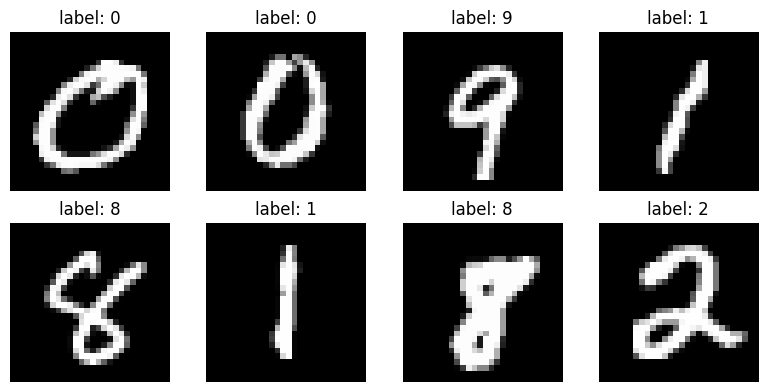

In [15]:
# Podgląd kilku obrazków z etykietami
images, labels = next(iter(train_loader))
print("Kształt batcha obrazów:", images.shape)  # (batch_size, 1, 28, 28)

fig = plt.figure(figsize=(8, 4))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(images[i].squeeze(0), cmap="gray")
    ax.set_title(f"label: {labels[i].item()}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## 5. Prosta sieć neuronowa dla MNIST

Zbudujemy prostą sieć neuronową, która dostaje na wejściu spłaszczony obraz 28×28 (czyli 784 piksele),
kilka warstw ukrytych oraz wyjście o rozmiarze 10 (klasy cyfr 0–9).

In [16]:
class MNISTNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.flatten(x, start_dim=1)  # spłaszczamy obraz (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  # bez softmax – użyjemy CrossEntropyLoss

        return x

model = MNISTNet().to(device)
print(model)

MNISTNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### Pętla treningowa

Schemat uczenia jest typowy:

1. Pobieramy batch danych `(images, labels)`,
2. Liczymy predykcję modelu,
3. Obliczamy stratę (`loss`),
4. Wywołujemy `loss.backward()` aby policzyć gradienty,
5. Wywołujemy `optimizer.step()` aby zaktualizować wagi,
6. (Opcjonalnie) liczymy dokładność na zbiorze treningowym i testowym,
7. Zapisujemy wyniki, aby później je **zwizualizować**.

In [17]:
epochs = 5
learning_rate = 1e-3

criterion = torch.nn.CrossEntropyLoss()  # funkcja straty dla klasyfikacji wieloklasowej
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # optymalizator Adam, która aktualizuje wagi modelu

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):  # iterowanie się po epokach
    model.train()  # ustawienie modelu w tryb treningowy
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:  # iterowanie się po batchach w zbiorze treningowym
        images, labels = images.to(device), labels.to(device)  # przeniesienie danych na odpowiednie urządzenie i podział ich na obrazy i etykiety

        optimizer.zero_grad()               # wyzerowanie gradientów z poprzedniego kroku inaczej będą się sumować
        outputs = model(images)             # policzenie predykcji modelu dla danych
        loss = criterion(outputs, labels)   # liczenie lossu
        loss.backward()                     # liczenie gradientów
        optimizer.step()                    # aktualizacja wag w modelu na podstawe gradientów

        running_loss += loss.item() * labels.size(0)  # śledzenie łącznego lossu
        _, predicted = outputs.max(1)  # przekształcenie wyników modelu na przewidywane klasy
        total += labels.size(0)  # całkowita liczba przykładów
        correct += (predicted == labels).sum().item()  # liczba poprawnych predykcji modelu - w ilu miejscach przewidział dobrze

    epoch_loss = running_loss / total  # średni loss w tej epoce
    epoch_acc = correct / total  # dokładność w tej epoce
    train_losses.append(epoch_loss)  # zapisanie średniego lossu
    train_accuracies.append(epoch_acc)  # zapisanie dokładności

    # --- ewaluacja na zbiorze testowym ---
    model.eval()  # ustawienie modelu w tryb ewaluacyjny - czasami wyniki na niektórych warstwach różnią się w trybie treningowym i ewaluacyjnym
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():  # wyłączenie liczenia gradientów podczas ewaluacji - oszczędza pamięć i przyspiesza obliczenia
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"train_loss={epoch_loss:.4f}, train_acc={epoch_acc:.4f}, "
        f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}"
    )


Epoch [1/5] train_loss=0.3414, train_acc=0.9057, test_loss=0.1756, test_acc=0.9485
Epoch [2/5] train_loss=0.1381, train_acc=0.9588, test_loss=0.1118, test_acc=0.9659
Epoch [3/5] train_loss=0.0925, train_acc=0.9721, test_loss=0.0903, test_acc=0.9714
Epoch [4/5] train_loss=0.0708, train_acc=0.9778, test_loss=0.0859, test_acc=0.9740
Epoch [5/5] train_loss=0.0562, train_acc=0.9826, test_loss=0.0745, test_acc=0.9766


## 6. Wizualizacja procesu uczenia

Mając zapisane wartości straty i dokładności w każdej epoce, możemy narysować wykresy,
które ułatwią zrozumienie, czy model faktycznie się uczy.

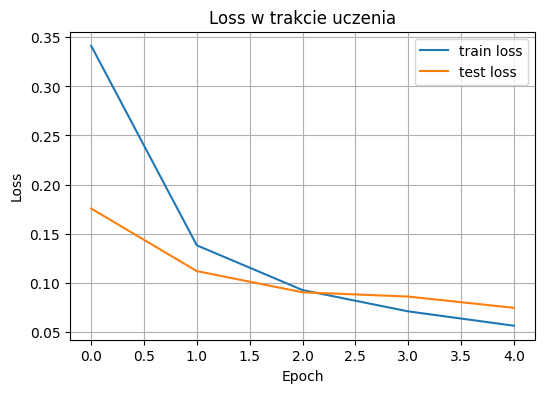

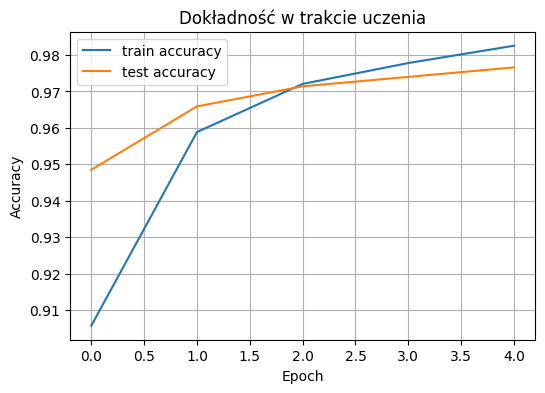

In [18]:
# Wykres strat treningowych i testowych
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss w trakcie uczenia")
plt.legend()
plt.grid(True)
plt.show()

# Wykres dokładności
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label="train accuracy")
plt.plot(test_accuracies, label="test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Dokładność w trakcie uczenia")
plt.legend()
plt.grid(True)
plt.show()

### Podgląd predykcji i błędnych klasyfikacji

Na koniec obejrzymy kilka przykładów z zestawu testowego: co było etykietą prawdziwą,
a co przewidział model.

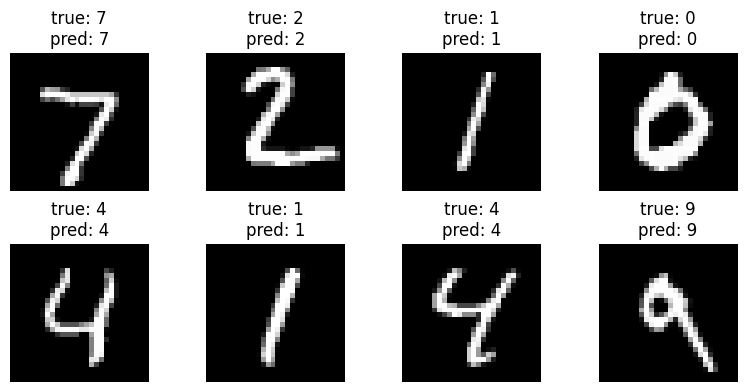

In [19]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = outputs.max(1)

fig = plt.figure(figsize=(8, 4))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1)
    ax.imshow(images[i].cpu().squeeze(0), cmap="gray")
    ax.set_title(f"true: {labels[i].item()}\npred: {preds[i].item()}")
    ax.axis("off")
plt.tight_layout()
plt.show()